#SETUP

In [ ]:
!pip install rioxarray --upgrade
!pip install rasterstats
!pip install pandas rasterio --upgrade
import os
import re
import sys
import random
from pathlib import Path

import requests
import json
import xml.etree.ElementTree as ET
import certifi

import pandas as pd
import numpy as np

import rasterio
import matplotlib.pyplot as plt
import matplotlib.image
from rasterio.windows import Window

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 35.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 2.2.2 which is incompatible.


#convert SENTINEL 3 LST into TIFF file

In [ ]:
%cd /content/drive/MyDrive/4/S3B_SL_2_LST____20230331T165945_20230331T170245_20230401T124348_0179_077_383_0180_PS2_O_NT_004.SEN3

import rioxarray
from rasterio.control import GroundControlPoint

with rioxarray.open_rasterio(f'netcdf:geodetic_in.nc:latitude_in') as lat:
  with rioxarray.open_rasterio(f'netcdf:geodetic_in.nc:longitude_in') as lon:
    with rioxarray.open_rasterio(f'netcdf:geodetic_in.nc:elevation_in') as alt:
      with rioxarray.open_rasterio(f'netcdf:LST_in.nc:LST') as LST:

        nof_gcp_x = np.arange(0, LST.x.size, 30)
        nof_gcp_y = np.arange(0, LST.y.size, 30)
        gcps = []
        id = 0

        for x in nof_gcp_x:
          for y in nof_gcp_y:
            gcps.append(GroundControlPoint(row=y, col=x, x=lon.data[0, y, x]*lon.scale_factor, y=lat.data[0, y, x] * lat.scale_factor, z=alt.data[0, y, x] * alt.scale_factor, id=id))
            id += 1
        tr_gcp = rasterio.transform.from_gcps(gcps)



def convert_to_tif(layer_name, title):
    with rioxarray.open_rasterio(f'netcdf:{layer_name}') as data:
        data.rio.write_crs("EPSG:4326", inplace=True)
        data.rio.write_transform(transform=tr_gcp, inplace=True)
        filename = layer_name.split(':')[1]
        if "_" in filename:
          filename =filename.split('_')[0]

        data.rio.to_raster(f"/content/drive/MyDrive/4/{title}_{filename}.tif", recalc_transform=False)
        data_Final = data.rio.reproject(dst_crs="EPSG:4326",gcps=gcps, **{"SRC_METHOD": "GCP_TPS"})

        data_Final.rio.to_raster(f"/content/drive/MyDrive/4/{title}_{filename}_reproj.tif", recalc_transform=False)
        print(f'Saved {layer_name}')

layer_name = ['LST_in.nc:LST','LST_ancillary_ds.nc:fraction','LST_ancillary_ds.nc:NDVI','LST_ancillary_ds.nc:biome','flags_in.nc:bayes_in','flags_in.nc:cloud_in']
for name in layer_name:
  convert_to_tif(name,title ='Sentinel-3_L2')


#visualize SENTINEL-3 LST vs NDVI

In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the LST raster
with rasterio.open('/content/drive/MyDrive/1/cdng43x.tif') as lst:
    lst_data = lst.read(1)

# Open the NDVI raster
with rasterio.open('/content/drive/MyDrive/1/cdng43x_reproj_32643.tif') as ndvi:
    ndvi_data = ndvi.read(1)

# Plot the rasters side by side
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 6))
ax1.imshow(lst_data, cmap='coolwarm')
ax1.set_title('LST')
ax2.imshow(ndvi_data, cmap='RdYlGn')
ax2.set_title('NDVI')
plt.show()

#Reproject LST into UTM tranform to regional transform

In [ ]:
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import Transformer

input_raster = '/content/drive/MyDrive/1/cdng43x.tif'
output_raster = '/content/drive/MyDrive/1/cdng43x_reproj_32643.tif'
dst_crs = 'EPSG:32643'

# Read the input raster file
with rasterio.open(input_raster) as src:
    # Get the transform, width, and height for the destination CRS
    transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
    # Set up the destination
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height,
        'dtype': np.float32,
    })



    # Create the destination and write the reprojected data
    with rasterio.open(output_raster, 'w', **kwargs) as dst:
        # Perform the reprojection
        for i in range(1, src.count + 1):
            reproject(
                source=src.read(1).astype(np.float32)* src.scales[0] + src.offsets[0],
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.bilinear)

# Clip LST with Sentinel 2

In [ ]:
import rasterio
import numpy as np

# Open the two raster files
with rasterio.open('/content/drive/MyDrive/4/IMG_DATA/R10m/T43QDC_20230529T052651_B08_10m.jp2') as small_raster:
    with rasterio.open('/content/drive/MyDrive/4/Sentinel-3_L2_LST_reproj_32643.tif') as big_raster:

        # Get the extent of the smaller raster
        min_x, min_y, max_x, max_y = small_raster.bounds

        # Read the data from the bigger raster within the extent of the smaller raster
        window = rasterio.windows.from_bounds(min_x, min_y, max_x, max_y, big_raster.transform)
        data = big_raster.read(window=window)

        # Update the metadata of the bigger raster to match the extent of the smaller raster
        clipped_meta = big_raster.meta.copy()
        clipped_meta.update({
            'height': window.height,
            'width': window.width,
            'transform': rasterio.windows.transform(window, big_raster.transform),
            'dtype': data.dtype
        })

        # Write the clipped data
        with rasterio.open('/content/drive/MyDrive/4/Sentinel-3_L2_LST_reproj_32643_clipped.tif', 'w', **clipped_meta) as clipped_raster:
            clipped_raster.write(data)

#visualize sentinel 2 calculated ndvi vs LST

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show

# File paths
nir_path = '/content/drive/MyDrive/3/IMG_DATA/R20m/T43PGL_20230418T050659_B8A_20m.jp2'
red_path = '/content/drive/MyDrive/3/IMG_DATA/R20m/T43PGL_20230418T050659_B11_20m.jp2'

clipped_temperature_path = '/content/drive/MyDrive/3/Sentinel-3_L2_LST_reproj_32643_clipped.tif'

# Read raster data
with rasterio.open(red_path) as red_src:
  red = red_src.read(1)

with rasterio.open(nir_path) as nir_src:
  nir = nir_src.read(1)

with rasterio.open(clipped_temperature_path) as clipped_temp_ds:
  clipped_temperature = clipped_temp_ds.read(1)

# Calculate NDVI
ndvi = (red - nir) / (red + nir)

# Plot NDVI and temperature side by side
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12, 6))

# Plot NDVI
im1 = ax1.imshow(ndvi,  vmin=0, vmax=16)
ax1.set_title('NDVI', fontweight='bold', fontsize=14)
fig.colorbar(im1, ax=ax1, shrink=0.5)

# Plot clipped temperature
im2= ax2.imshow(clipped_temperature,  vmin=280, vmax=320)
ax2.set_title('Clipped temp', fontweight='bold', fontsize=14)
fig.colorbar(im2, ax=ax2, shrink=0.5)
plt.show()
# plt.hist(ndvi)
# plt.hist(clipped_temperature)

#Create Dataset with different Scaling Factors(indices)

In [ ]:
import rasterio
import rasterio.features
import rasterio.mask
import pandas as pd
import geopandas as gpd
import rasterstats
import cv2
import rasterio
from rasterio.features import shapes
mask = None

# Open the input raster
with rasterio.open('/content/drive/MyDrive/1/Sentinel-3_L2_LST_reproj_32643_clipped.tif') as src:
    # Read the raster band
    image = src.read(1).astype(np.float32)* src.scales[0] + src.offsets[0]

    results = (
        {'properties': {'Temperature': v}, 'geometry': s}
        for i, (s, v)
        in enumerate(
            shapes(image, mask=mask, transform=src.transform)))
    geoms = list(results)
    gpd_polygonized_raster  = gpd.GeoDataFrame.from_features(geoms)



# Open the rasters
with rasterio.open('/content/drive/MyDrive/1/bands2/R10m/T43RGH_20240311T051651_B08_10m.jp2') as nir_src:
  with rasterio.open('/content/drive/MyDrive/1/bands2/R10m/T43RGH_20240311T051651_B04_10m.jp2') as red_src:

        # Read the data as float32
        nir = nir_src.read(1).astype(np.float32)* nir_src.scales[0] + nir_src.offsets[0]
        red = red_src.read(1).astype(np.float32)* red_src.scales[0] + red_src.offsets[0]

        # Calculate NDVI
        ndvi = (nir - red) / (nir + red)

        # Calculate the zonal statistics for each polygon
        stats = rasterstats.zonal_stats(gpd_polygonized_raster.geometry, ndvi, affine=nir_src.transform, stats='mean')

        # Add the mean value of NDVI to the dataframe
        gpd_polygonized_raster['NDVI'] = [s['mean'] for s in stats]

with rasterio.open('/content/drive/MyDrive/1/bands2/R20m/T43RGH_20240311T051651_B03_20m.jp2') as g_src:
  with rasterio.open('/content/drive/MyDrive/1/bands2/R20m/T43RGH_20240311T051651_B8A_20m.jp2') as nir_src:

        # Read the data as float32
        g = g_src.read(1).astype(np.float32)* g_src.scales[0] + g_src.offsets[0]
        nir = nir_src.read(1).astype(np.float32)* nir_src.scales[0] + nir_src.offsets[0]

        # Calculate NDVI
        ndwi = (g - nir) / (g + nir)

        # Calculate the zonal statistics for each polygon
        stats = rasterstats.zonal_stats(gpd_polygonized_raster.geometry, ndwi, affine=g_src.transform, stats='mean')

        # Add the mean value of NDVI to the dataframe
        gpd_polygonized_raster['MNDWI'] = [s['mean'] for s in stats]

with rasterio.open('/content/drive/MyDrive/1/bands2/R20m/T43RGH_20240311T051651_B8A_20m.jp2') as vnir_src:
  with rasterio.open('/content/drive/MyDrive/1/bands2/R20m/T43RGH_20240311T051651_B11_20m.jp2') as swir_src:

        # Read the data as float32
        vnir = vnir_src.read(1).astype(np.float32)* vnir_src.scales[0] + vnir_src.offsets[0]
        swir = swir_src.read(1).astype(np.float32)* swir_src.scales[0] + swir_src.offsets[0]

        # Calculate NDVI
        NDMI = (vnir - swir) / (vnir + swir)

        # Calculate the zonal statistics for each polygon
        stats = rasterstats.zonal_stats(gpd_polygonized_raster.geometry, NDMI, affine=vnir_src.transform, stats='mean')

        # Add the mean value of NDVI to the dataframe
        gpd_polygonized_raster['NDMI'] = [s['mean'] for s in stats]

with rasterio.open('/content/drive/MyDrive/1/bands2/R20m/T43RGH_20240311T051651_B03_20m.jp2') as g_src:
  with rasterio.open('/content/drive/MyDrive/1/bands2/R20m/T43RGH_20240311T051651_B11_20m.jp2') as swir_src:

        # Read the data as float32
        g = g_src.read(1).astype(np.float32)* g_src.scales[0] + g_src.offsets[0]
        swir = swir_src.read(1).astype(np.float32)* swir_src.scales[0] + swir_src.offsets[0]

        # Calculate NDVI
        ndsi = (g - swir) / (g + swir)

        # Calculate the zonal statistics for each polygon
        stats = rasterstats.zonal_stats(gpd_polygonized_raster.geometry, ndsi, affine=g_src.transform, stats='mean')

        # Add the mean value of NDVI to the dataframe
        gpd_polygonized_raster['NDSI'] = [s['mean'] for s in stats]


with rasterio.open('/content/drive/MyDrive/1/bands2/R10m/T43RGH_20240311T051651_B08_10m.jp2') as nir_src:
  with rasterio.open('/content/drive/MyDrive/1/bands2/R10m/T43RGH_20240311T051651_B02_10m.jp2') as blue_src:

        # Read the data as float32
        nir = nir_src.read(1).astype(np.float32)* nir_src.scales[0] + nir_src.offsets[0]
        blue = blue_src.read(1).astype(np.float32)* blue_src.scales[0] + blue_src.offsets[0]

        # Calculate NDVI
        bndvi = (nir - blue) / (nir + blue)

        # Calculate the zonal statistics for each polygon
        stats = rasterstats.zonal_stats(gpd_polygonized_raster.geometry, bndvi, affine=nir_src.transform, stats='mean')

        # Add the mean value of NDVI to the dataframe
        gpd_polygonized_raster['BNDVI'] = [s['mean'] for s in stats]

with rasterio.open('/content/drive/MyDrive/1/bands2/R10m/T43RGH_20240311T051651_B03_10m.jp2') as green_src:
  with rasterio.open('/content/drive/MyDrive/1/bands2/R10m/T43RGH_20240311T051651_B04_10m.jp2') as red_src:

        # Read the data as float32
        green = green_src.read(1).astype(np.float32)* green_src.scales[0] + green_src.offsets[0]
        red = red_src.read(1).astype(np.float32)* red_src.scales[0] + red_src.offsets[0]

        # Calculate NDVI
        NGRDI = (green - red) / (green + red)

        # Calculate the zonal statistics for each polygon
        stats = rasterstats.zonal_stats(gpd_polygonized_raster.geometry, NGRDI, affine=green_src.transform, stats='mean')

        # Add the mean value of NDVI to the dataframe
        gpd_polygonized_raster['NGRDI'] = [s['mean'] for s in stats]



with rasterio.open('/content/drive/MyDrive/1/bands2/R10m/T43RGH_20240311T051651_B08_10m.jp2') as nir_src:
  with rasterio.open('/content/drive/MyDrive/1/bands2/R10m/T43RGH_20240311T051651_B04_10m.jp2') as red_src:
    with rasterio.open('/content/drive/MyDrive/1/bands2/R10m/T43RGH_20240311T051651_B03_10m.jp2') as green_src:

        # Read the data as float32
        nir = nir_src.read(1).astype(np.float32)* nir_src.scales[0] + nir_src.offsets[0]
        green = green_src.read(1).astype(np.float32)* green_src.scales[0] + green_src.offsets[0]
        red = red_src.read(1).astype(np.float32)* red_src.scales[0] + red_src.offsets[0]

        # Calculate NDVI
        NORMG  =  green/(nir+green+red)
        NORMR  =  red/(nir+green+red)
        NORMNIR  =  nir/(nir+green+red)

        # Calculate the zonal statistics for each polygon
        stats = rasterstats.zonal_stats(gpd_polygonized_raster.geometry, NORMG, affine=green_src.transform, stats='mean')
        stats2 = rasterstats.zonal_stats(gpd_polygonized_raster.geometry, NORMR, affine=green_src.transform, stats='mean')
        stats3 = rasterstats.zonal_stats(gpd_polygonized_raster.geometry, NORMNIR, affine=green_src.transform, stats='mean')

        # Add the mean value of NDVI to the dataframe
        gpd_polygonized_raster['NORMG'] = [s['mean'] for s in stats]
        gpd_polygonized_raster['NORMR'] = [s['mean'] for s in stats2]
        gpd_polygonized_raster['NORMNIR'] = [s['mean'] for s in stats3]


with rasterio.open('/content/drive/MyDrive/1/bands2/R20m/T43RGH_20240311T051651_B12_20m.jp2') as swir_src:
  with rasterio.open('/content/drive/MyDrive/1/bands2/R20m/T43RGH_20240311T051651_B11_20m.jp2') as nir_src:

        # Read the data as float32
        swir = swir_src.read(1).astype(np.float32)* swir_src.scales[0] + swir_src.offsets[0]
        nir = nir_src.read(1).astype(np.float32)* nir_src.scales[0] + nir_src.offsets[0]

        # Calculate NDVI
        ndbs = (swir - nir) / (swir + nir)

        # Calculate the zonal statistics for each polygon
        stats = rasterstats.zonal_stats(gpd_polygonized_raster.geometry, ndbs, affine=nir_src.transform, stats='mean')

        # Add the mean value of NDVI to the dataframe
        gpd_polygonized_raster['NDBS'] = [s['mean'] for s in stats]



# Save the polygon layer to a shapefile
gpd_polygonized_raster.to_file('output_polygons.shp')

# Create a pandas dataframe from the geodataframe
stats_df = pd.DataFrame(gpd_polygonized_raster.drop(columns='geometry'))

# Print the dataframe
print(stats_df)

In [ ]:
# Drop rows with NaN values
df_clean = stats_df.dropna(subset=['NDVI'])
df_clean = df_clean.dropna(subset=['MNDWI'])
df_clean = df_clean.dropna(subset=['NDMI'])
df_clean = df_clean.dropna(subset=['NDSI'])
df_clean = df_clean.dropna(subset=['BNDVI'])
df_clean = df_clean.dropna(subset=['NGRDI'])
df_clean = df_clean.dropna(subset=['NORMG'])
df_clean = df_clean.dropna(subset=['NORMR'])
df_clean = df_clean.dropna(subset=['NORMNIR'])
df_clean = df_clean.dropna(subset=['NDBS'])
df_clean.to_csv("/content/drive/MyDrive/1/corr3.csv")
df_clean

In [ ]:
# df_clean = pd.read_csv('/content/drive/MyDrive/sharpening/1/corr.csv')
from sklearn.preprocessing import StandardScaler
TargetVariable = ['Temperature']
Predictors = ['NDVI','NDWI', 'NDMI', 'NDSI' ,'GNDVI','BNDVI','NGRDI','NORMG','NORMR','NORMNIR']
x=indices[Predictors].values
y=indices[TargetVariable].values
PredictorScaler=StandardScaler()
TargetVarScaler=StandardScaler()

PredictorScalerFit=PredictorScaler.fit(x)
TargetVarScalerFit=TargetVarScaler.fit(y)

X=PredictorScalerFit.transform(x)
Y=TargetVarScalerFit.transform(y)

#Feature Selection

Correlation visualization

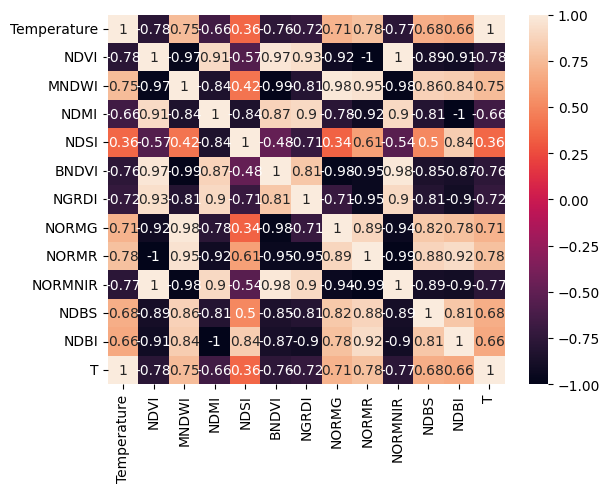

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_clean = pd.read_csv('/content/drive/MyDrive/1/corrn.csv')
df_clean = df_clean.drop(df_clean.columns[0], axis=1)
df_clean = df_clean.drop(df_clean.columns[0], axis=1)
matrix = df_clean.corr().round(2)
sns.heatmap(matrix, annot=True)
plt.show()

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


sns.pairplot(df_clean)
plt.show()

In [ ]:
df_clean

,Temperature,NDVI,MNDWI,NDMI,NDSI,BNDVI,NGRDI,NORMG,NORMR,NORMNIR,NDBS,NDBI,T
0,0.979725,0.358078,-18.141704,-0.156411,4.669329,0.589566,-1.290907,0.743718,0.887116,0.730275,-0.829518,0.213447,312.698273
1,0.979405,0.294525,-17.577670,-0.448215,5.544473,0.601151,-1.894126,0.728720,0.931292,0.714044,-0.702208,0.611658,312.596100
2,0.980141,0.268212,-16.710591,-0.585368,5.830479,0.557913,-1.847206,0.744475,0.941026,0.699658,-0.792215,0.798825,312.830872
3,0.981009,0.307415,-17.814234,-0.478407,5.687111,0.587145,-1.788656,0.733219,0.922658,0.716328,-0.726569,0.652860,313.107849
4,0.981664,0.316548,-17.337712,-0.496056,5.645015,0.556913,-1.523830,0.748077,0.911215,0.714308,-0.849538,0.676944,313.316895
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11146,0.972720,0.549922,-22.161838,0.230867,4.126146,0.740992,-0.836775,0.699584,0.792316,0.808391,-1.263833,-0.315053,310.462402
11147,0.975895,0.379522,-18.489956,-0.035708,4.267430,0.623183,-1.319153,0.736798,0.878368,0.739098,-1.100213,0.048729,311.475616
11148,0.970360,0.655956,-23.774898,0.373881,3.967371,0.790119,-0.349623,0.686412,0.734660,0.848148,-1.391700,-0.510219,309.709229
11149,0.971128,0.586736,-22.777428,0.267427,4.129671,0.757509,-0.704090,0.693644,0.773163,0.822486,-1.330399,-0.364946,309.954437


recursive feature elimination (RFE)

In [ ]:
# df_clean = pd.read_csv('/content/drive/MyDrive/1/corrn.csv')
dff = df_clean.drop('Temperature', axis=1)
# dff = dff.drop(dff.columns[0], axis=1)
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()
RFE_selector = RFE(estimator=dt, n_features_to_select=3, step=1)
RFE_selector.fit(dff, df_clean['Temperature'])

RFE(estimator=DecisionTreeRegressor(), n_features_to_select=3)

In [ ]:
plot(RFE_selector)

NameError: name 'plot' is not defined

In [ ]:
from sklearn.feature_selection import RFE
RFE_selector2 = RFE(estimator=svm, n_features_to_select=3, step=1)
RFE_selector2.fit(dff, df_clean['Temperature'])

In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot

# feature selection
def select_features(X_train, y_train, X_test):
 # configure to select all features
 fs = SelectKBest(score_func=f_regression, k='all')
 # learn relationship from training data
 fs.fit(X_train, y_train)
 # transform train input data
 X_train_fs = fs.transform(X_train)
 # transform test input data
 X_test_fs = fs.transform(X_test)
 return X_train_fs, X_test_fs, fs
X = df[['NDVI','MNDWI','NDMI','NDSI','BNDVI','NGRDI','NORMR','NORMNIR','NDBS','NDBI']]
X_train, X_test, y_train, y_test = train_test_split(X, df.Temperature, test_size=0.33, random_state=1)
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
 print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

#Choose any ALGORITHM

In [ ]:
#Linear Regression
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit()

,NDVI,MNDWI,NDMI,NDSI,BNDVI,NGRDI,NORMG,NORMR,NORMNIR,NDBS,NDBI,T
0,0.358078,-18.141704,-0.156411,4.669329,0.589566,-1.290907,0.743718,0.887116,0.730275,-0.829518,0.213447,312.698273
1,0.294525,-17.577670,-0.448215,5.544473,0.601151,-1.894126,0.728720,0.931292,0.714044,-0.702208,0.611658,312.596100
2,0.268212,-16.710591,-0.585368,5.830479,0.557913,-1.847206,0.744475,0.941026,0.699658,-0.792215,0.798825,312.830872
3,0.307415,-17.814234,-0.478407,5.687111,0.587145,-1.788656,0.733219,0.922658,0.716328,-0.726569,0.652860,313.107849
4,0.316548,-17.337712,-0.496056,5.645015,0.556913,-1.523830,0.748077,0.911215,0.714308,-0.849538,0.676944,313.316895
...,...,...,...,...,...,...,...,...,...,...,...,...
11146,0.549922,-22.161838,0.230867,4.126146,0.740992,-0.836775,0.699584,0.792316,0.808391,-1.263833,-0.315053,310.462402
11147,0.379522,-18.489956,-0.035708,4.267430,0.623183,-1.319153,0.736798,0.878368,0.739098,-1.100213,0.048729,311.475616
11148,0.655956,-23.774898,0.373881,3.967371,0.790119,-0.349623,0.686412,0.734660,0.848148,-1.391700,-0.510219,309.709229
11149,0.586736,-22.777428,0.267427,4.129671,0.757509,-0.704090,0.693644,0.773163,0.822486,-1.330399,-0.364946,309.954437


In [ ]:
#Random forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
reg2 = RandomForestRegressor()
reg2.fit(dff[['NDVI','MNDWI','BNDVI']],df_clean['Temperature'])

In [ ]:
k = df_clean['Temperature'] - reg2.predict(dff[['NDVI','MNDWI','BNDVI']])

In [ ]:
#Lasso regressor
from sklearn.linear_model import Lasso
alphas = [0.01,2,3,5,10,15,20,30,40,50,100]
for i in alphas:
  L = Lasso(alpha = i)
  L.fit(x,y)
  print(L.coef_)

In [ ]:
#Ridge regressor
from sklearn.linear_model import Ridge
alphas = [0.0001,0.001,0.01,1,2,3,5,10,15,20,40,80,100,200]
for i in alphas:
  L = Ridge(alpha = i)
  L.fit(X_train,y_train)
  print(L.coef_)

In [ ]:
#ANN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

TargetVariable = ['Temperature']
Predictors = ['NDVI','MNDWI','BNDVI']
# Predictors = ['NDVI','MNDWI']
x=df_clean[Predictors].values
y=df_clean[TargetVariable].values

# PredictorScaler=StandardScaler()
# TargetVarScaler=StandardScaler()

# PredictorScalerFit=PredictorScaler.fit(x)
# TargetVarScalerFit=TargetVarScaler.fit(y)

# X=PredictorScalerFit.transform(x)
# Y=TargetVarScalerFit.transform(y)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

#train
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
model = Sequential()

model.add(Dense(units=4, input_dim=2, kernel_initializer='normal',activation='relu'))
model.add(Dense(units=10, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='linear'))


model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
#find optimal hyperparameter
def FunctionFindBestParams(X_train, y_train, X_test, y_test):
  # Defining the list of hyper parameters to try
    batch_size_list=[10, 15, 20]
    epoch_list  =   [10, 50]

    import pandas as pd
    SearchResultsData=pd.DataFrame(columns=['TrialNumber', 'Parameters', 'Accuracy'])

    # initializing the trials
    TrialNumber=0
    for batch_size_trial in batch_size_list:
        for epochs_trial in epoch_list:
            TrialNumber+=1
            # create ANN model
            model = Sequential()
            # Defining the first layer of the model
            model.add(Dense(units=5, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))

            # Defining the Second layer of the model
            model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))

            # The output neuron is a single fully connected node
            # Since we will be predicting a single number
            model.add(Dense(1, kernel_initializer='normal'))

            # Compiling the model
            model.compile(loss='mean_squared_error', optimizer='adam')

            # Fitting the ANN to the Training set
            model.fit(X_train, y_train ,batch_size = batch_size_trial, epochs = epochs_trial, verbose=0)

            MAPE = np.mean(100 * (np.abs(y_test-model.predict(X_test))/y_test))

            # printing the results of the current iteration
            print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', 100-MAPE)

            SearchResultsData=pd.concat([SearchResultsData,pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE]],
                                                                    columns=['TrialNumber', 'Parameters', 'Accuracy'] )])
    return(SearchResultsData)


######################################################
# Calling the function
ResultsData=FunctionFindBestParams(X_train, y_train, X_test, y_test)

In [ ]:
history = model.fit(X_train, y_train ,batch_size = 10, epochs = 20, verbose=1)


plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
Predictions=model.predict(X_test)

# Scaling the predicted Price data back to original price scale
Predictions=TargetVarScalerFit.inverse_transform(Predictions)

# Scaling the y_test Price data back to original price scale
y_test_orig=TargetVarScalerFit.inverse_transform(y_test)

# Scaling the test data back to original scale
Test_Data=PredictorScalerFit.inverse_transform(X_test)

TestingData=pd.DataFrame(data=Test_Data, columns=Predictors)
TestingData['TEMP']=y_test_orig
TestingData['PredictedTEMP']=Predictions
TestingData.head()

#Residual Correction coefficient

In [ ]:
k = y_test - model.predict()

# Sharpening

In [ ]:
# df_clean = pd.read_csv('/content/drive/MyDrive/sharpening/1/corr.csv')
from sklearn.preprocessing import StandardScaler
TargetVariable = ['Temperature']
Predictors = ['NDVI','MNDWI','BNDVI']
x=dff[Predictors].values
y=df_clean[TargetVariable].values
PredictorScaler=StandardScaler()
TargetVarScaler=StandardScaler()

PredictorScalerFit=PredictorScaler.fit(x)
TargetVarScalerFit=TargetVarScaler.fit(y)

# X=PredictorScalerFit.transform(x)
# Y=TargetVarScalerFit.transform(y)

In [ ]:
import statistics
k = statistics.mean(k)
test1 = test
# test1['NDMI'] = (-1)*test1['NDMI']
# Predictors = ['NDVI','NDWI','VI','NDSI','GNDVI','BNDVI','NGRDI','RI','NORMG','NORMR','NORMNIR','NDBI']

T=test1[['NDVI','MNDWI','BNDVI']].values



# PredictorScalerFit=PredictorScaler.fit(T)

T=PredictorScalerFit.transform(T)
# array = x[8262:]

new_y = reg2.predict(T) + k
# new_y =TargetVarScalerFit.inverse_transform(new_y)

ndvi_cmap = plt.cm.RdYlGn
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

# Plot temperature
with rasterio.open('/content/drive/MyDrive/1/Sentinel-3_L2_LST_reproj_32643_clipped.tif') as src:
    original_temp = src.read(1)

vmin, vmax = original_temp.min(), original_temp.max()
temp_subset = original_temp[int(0.75 * original_temp.shape[0]):, int(0.75 * original_temp.shape[1]):]
# temp_subset = TargetVarScalerFit.transform(temp_subset)
im1 = axs[0].imshow(temp_subset, cmap=ndvi_cmap.reversed())
axs[0].set_title('Temperature', fontweight='bold', fontsize=14)
axs[0].set_xticks([])
axs[0].set_yticks([])
fig.colorbar(im1, ax=axs[0], shrink=0.7)

# Plot NDVI
new_y = np.reshape(new_y, (2745, 2745))
# new_y = np.reshape(new_y, (27, 107))
new_y2 = new_y[int(0.75 * new_y.shape[0]):,int(0.75 * new_y.shape[1]):]
im2 = axs[1].imshow(new_y2, cmap=ndvi_cmap.reversed())
axs[1].set_title('ANN', fontweight='bold', fontsize=14)
axs[1].set_xticks([])
axs[1].set_yticks([])
fig.colorbar(im2, ax=axs[1], shrink=0.7)

# Plot temperature
vmin, vmax = 300, 315
new_y = np.reshape(new_y, (27, 107))
im3 = axs[2].imshow(new_y, cmap=ndvi_cmap.reversed())#, vmin=vmin, vmax=vmax)
axs[2].set_title('RFE', fontweight='bold', fontsize=14)
axs[2].set_xticks([])
axs[2].set_yticks([])
fig.colorbar(im3, ax=axs[2], shrink=0.7)

# Adjust the spacing between the subplots
fig.subplots_adjust(wspace=0.2)


plt.show()

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/1/test2.csv')


In [ ]:
test

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,NDVI,NDWI,VI,NDSI,GNDVI,BNDVI,NGRDI,RI,NORMG,NORMR,NORMNIR,NDBI,MNDWI
0,0,0,0,0,0.160075,12.915713,9.433460,11.565739,0.236203,0.314554,15.777643,0.079119,0.263829,0.309164,0.427007,0.055157,0.271744
1,1,1,1,1,0.157257,13.078862,9.614456,11.655491,0.241463,0.317515,15.935941,0.087531,0.261198,0.311310,0.427492,0.063028,0.257019
2,2,2,2,2,0.154111,13.147815,9.641096,11.617055,0.232340,0.313888,15.934506,0.081134,0.264416,0.311111,0.424473,0.066439,0.248885
3,3,3,3,3,0.158133,12.972581,9.513382,11.450432,0.240323,0.326720,15.821359,0.085437,0.261812,0.310728,0.427460,0.065392,0.247342
4,4,4,4,4,0.167564,12.196510,9.406639,11.255271,0.234446,0.318744,15.037805,0.069617,0.265806,0.305585,0.428609,0.063139,0.238206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7535020,7535020,7535020,7535020,7535020,0.244106,12.199847,0.007077,12.065720,0.309410,0.429167,16.763678,0.070640,0.247030,0.284583,0.468387,9.448275,0.304731
7535021,7535021,7535021,7535021,7535021,0.223731,12.132018,0.005871,11.882332,0.298938,0.410214,16.221891,0.080597,0.248254,0.291779,0.459968,9.366996,0.296464
7535022,7535022,7535022,7535022,7535022,0.218267,12.154138,2.278722,11.650995,0.286257,0.387387,16.093241,0.072521,0.252620,0.292126,0.455254,6.999986,0.286871
7535023,7535023,7535023,7535023,7535023,0.245056,11.676159,6.825628,11.371710,0.287331,0.389831,15.977995,0.045477,0.256303,0.280725,0.462973,2.347245,0.275954


In [ ]:
k

-8.758271609175699e-06